# Load Libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm.notebook import tqdm as tqdm
tqdm.pandas()

# Read Data

In [2]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv", parse_dates=['Date of Harvest'])
crop_yield_data.columns = ['district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
crop_yield_data.head()

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,2022-07-15,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,2022-07-15,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,2022-07-14,3.30,6400


In [3]:
crop_yield_data[crop_yield_data.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(['latitude', 'longitude'])

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
449,Thoai_Son,10.195117,105.200047,SA,T,2022-07-20,3.20,5600
531,Thoai_Son,10.195117,105.200047,WS,T,2022-05-04,3.20,7200
445,Thoai_Son,10.208515,105.202809,SA,T,2022-07-20,2.67,6400
527,Thoai_Son,10.208515,105.202809,WS,T,2022-05-04,2.67,7200
451,Thoai_Son,10.227394,105.164987,SA,T,2022-07-20,3.00,5600
...,...,...,...,...,...,...,...,...
119,Chau_Phu,10.636733,105.155635,WS,T,2022-10-04,3.20,8000
28,Chau_Phu,10.649258,105.142121,SA,D,2022-05-08,1.75,6000
120,Chau_Phu,10.649258,105.142121,WS,D,2022-10-04,1.75,8000
29,Chau_Phu,10.663484,105.168203,SA,D,2022-05-08,3.00,6500


In [4]:
sub_sample = pd.read_csv("Challenge_2_submission_template.csv", parse_dates=['Date of Harvest'])
sub_sample.columns = ['id', 'district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
sub_sample.head()

,id,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN


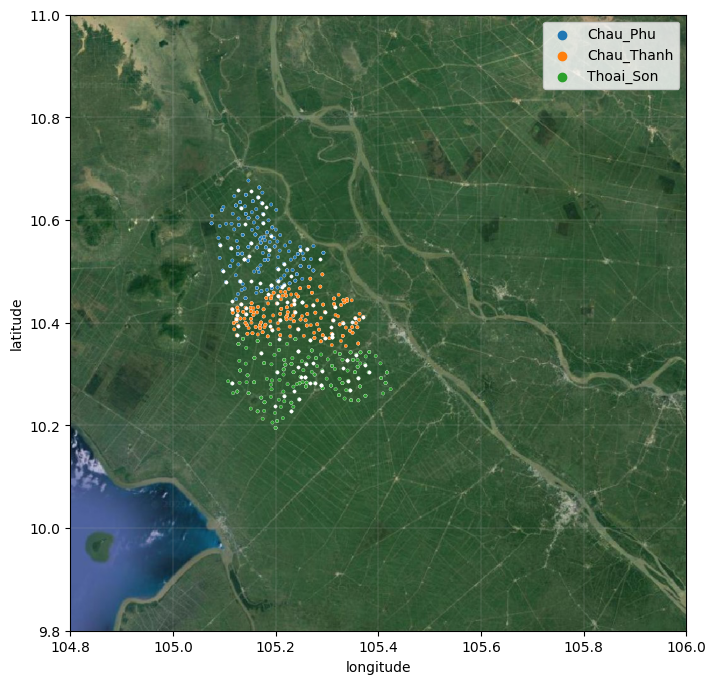

In [5]:
sns.scatterplot(data=crop_yield_data, x='longitude', y='latitude', hue='district', s=6)
sns.scatterplot(data=sub_sample, x='longitude', y='latitude', color='white', s=6)


fig = plt.gcf()
ax  = plt.gca()

fig.set_size_inches(8, 8)

ax.set_aspect('equal')
ax.patch.set_alpha(0)
plt.grid(lw=0.15)
plt.legend()
# legend.legendHandles[0]._sizes = [40]
# legend.legendHandles[1]._sizes = [40]
# legend.set_alpha(0)

plt.xlim(104.8, 106)
plt.ylim(9.8, 11)

# [0.06, 0, 0.95, 0.95]

newax = fig.add_axes(ax.get_position(), anchor='SW', zorder=-15)
# newax.set_position(ax.get_position())
newax.imshow(plt.imread('../Full Region no labels.jpg'), aspect='auto')
newax.axis('off')
# ax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# ax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
# newax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# newax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
plt.grid(False)

# Process Data

## Constant Features

<AxesSubplot:>

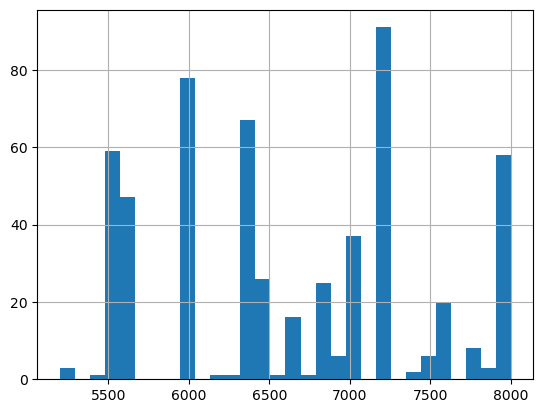

In [6]:
crop_yield_data['rice_yield'].hist(bins=30)

<AxesSubplot:>

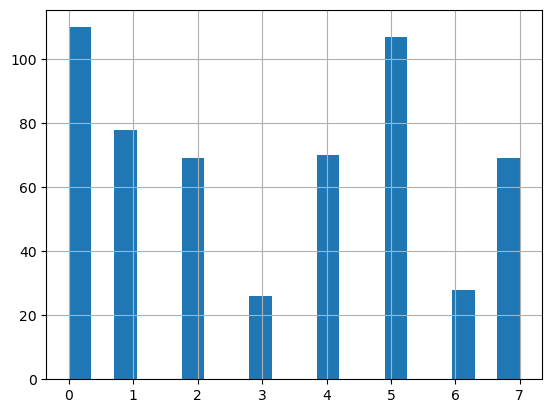

In [7]:
crop_yield_data['target_class'] = pd.qcut(crop_yield_data['rice_yield'], q=8, labels=False)
crop_yield_data['target_class'].hist(bins=20)

In [8]:
crop_yield_data.head(2)

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield,target_class
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500,0
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000,1


In [9]:
train_const_data = pd.get_dummies(crop_yield_data.drop(['district'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
sub_const_data   = pd.get_dummies(sub_sample.drop(['district', 'rice_yield', 'id'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T
0,2022-07-15,3.40,5500,0,0,1
1,2022-07-15,2.43,6000,1,0,1


,date_of_harvest,field_size,season_WS,intensity_T
0,2022-10-04,1.40,1,1
1,2022-07-15,1.32,0,1


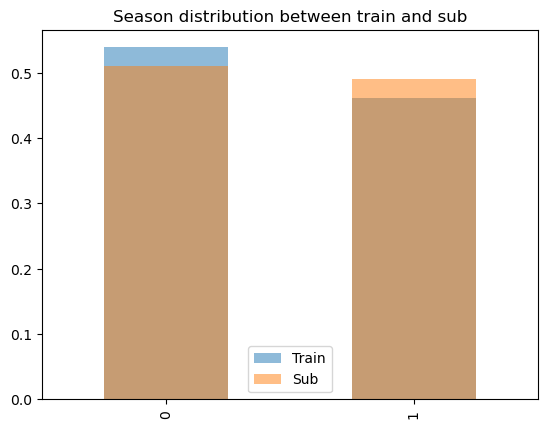

In [10]:
train_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, label='Train')
sub_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, color='C1', label='Sub')
plt.title('Season distribution between train and sub')
plt.legend();

In [11]:
train_const_data['start_of_harvest']     = train_const_data.date_of_harvest - pd.to_timedelta('99d')
sub_const_data  ['start_of_harvest']     = sub_const_data.date_of_harvest -   pd.to_timedelta('99d')
train_const_data['dayofyear_of_harvest'] = train_const_data.date_of_harvest.dt.day_of_year
sub_const_data['dayofyear_of_harvest']   = sub_const_data.date_of_harvest.dt.day_of_year
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-07-15,3.40,5500,0,0,1,2022-04-07,196
1,2022-07-15,2.43,6000,1,0,1,2022-04-07,196


,date_of_harvest,field_size,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-10-04,1.40,1,1,2022-06-27,277
1,2022-07-15,1.32,0,1,2022-04-07,196


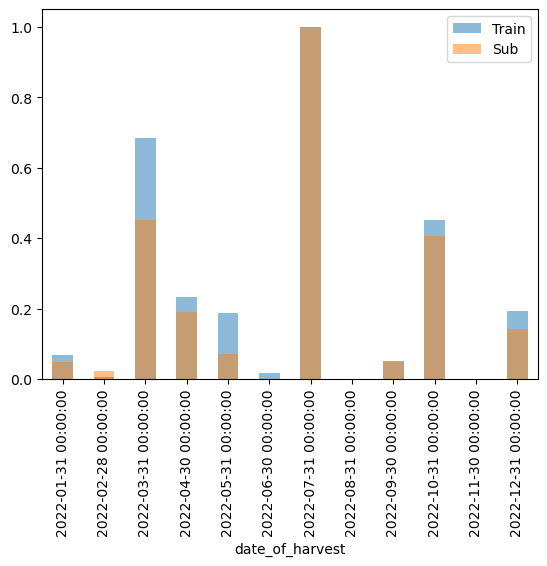

<AxesSubplot:>

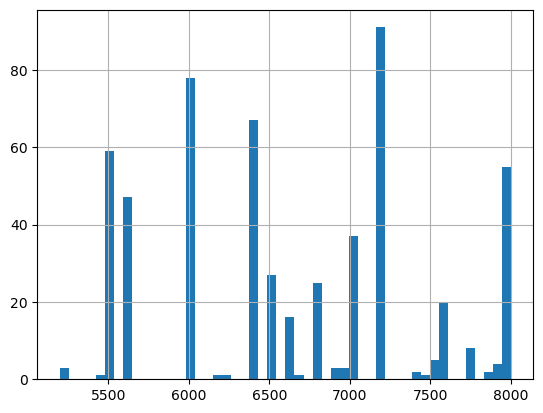

In [12]:
train_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, label='Train')
sub_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, color='C1', label='Sub')
plt.legend()
plt.show()
train_const_data.rice_yield.hist(bins=50)

In [13]:
# sns.kdeplot(data=train_const_data, x='date_of_harvest', y='rice_yield', hue='intensity_T', levels=8, fill=True, alpha=0.5)
# plt.title('Yield by date and by intensity')

In [14]:
# sns.heatmap(train_const_data.corr(), cmap='coolwarm', annot=True)

In [15]:
# sns.pairplot(train_const_data)

In [16]:
# sns.pairplot(sub_const_data)

## Time Series features

In [17]:
train_ts_data = pd.read_csv('train_data_level2.csv', index_col=['index', 'datetime'], parse_dates=True)
sub_ts_data   = pd.read_csv('sub_data_level2.csv'  , index_col=['index', 'datetime'], parse_dates=True)
# train_sent2_data = pd.read_csv('train_sentinel2_level2_fix.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)
# sub_sent2_data = pd.read_csv('sub_sentinel2_level2.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)

train_sent2_data = pd.read_pickle('../level2_sent2_train.df')
sub_sent2_data   = pd.read_pickle('../level2_sent2_sub.df'  )

display(train_ts_data.head(2), train_sent2_data.head(2), sub_sent2_data.head(2))

vh        vv       rvi
index datetime                                                
0     2021-09-05 22:45:35.619475  0.006411  0.036697  0.229400
      2021-09-11 22:46:08.311308  0.019033  0.295205  0.059627

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1739.746704  1636.0   1371.800049   2119.199951   
  2022-02-24 03:17:31.024          NaN     NaN           NaN           NaN   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  418.384033  2018.902222  1910.0   1629.800049   
  2022-02-24 03:17:31.024         NaN          NaN     NaN           NaN   

                                                     ...      rededge          \
                          percentile_80         std  ...         mean  median   
  time                                               ...                        
0 2022-02-19 03:17:49.024   2395.199951  439.676971  ...  2258.773438  2158.0   
  2022-02-24 03:17:31.024           NaN         NaN  ...          NaN     NaN   

                                                                       swir16  \
                          percentile_20 percentile_80        std         mean   
  time                                                                          
0 2022-02-19 03:17:49.024   1842.800049   2661.199951  478.83286  3002.666748   
  2022-02-24 03:17:31.024           NaN           NaN        NaN          NaN   

                                                                           
                           median percentile_20 percentile_80         std  
  time                                                                     
0 2022-02-19 03:17:49.024  2915.0        2506.0        3503.0  562.331221  
  2022-02-24 03:17:31.024     NaN           NaN           NaN         NaN  

[2 rows x 30 columns]

red                                        green  \
                          mean median percentile_20 percentile_80 std  mean   
  time                                                                        
0 2021-11-11 03:19:49.024  NaN    NaN           NaN           NaN NaN   NaN   
  2021-11-16 03:20:11.024  NaN    NaN           NaN           NaN NaN   NaN   

                                                                  ... rededge  \
                          median percentile_20 percentile_80 std  ...    mean   
  time                                                            ...           
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  ...     NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  ...     NaN   

                                                                 swir16  \
                          median percentile_20 percentile_80 std   mean   
  time                                                                    
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN    NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN    NaN   

                                                                  
                          median percentile_20 percentile_80 std  
  time                                                            
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  

[2 rows x 30 columns]

In [18]:
# Add ratio vv/vh
# train_ts_data = train_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# sub_ts_data = sub_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# display(train_ts_data.head(2), sub_ts_data.head(2))

# Add Indices to Sentinel 2
def AddBands(sent2_data, multiindex):
    if multiindex:
        sent2_data = sent2_data.stack()
    sent2_data = sent2_data.assign(ndvi =lambda x:(x.nir-x.red)/(x.nir+x.red),
                                           ndwi =lambda x:(x.nir-x.swir16)/(x.nir+x.swir16),
                                           ndbsi=lambda x:((x.nir+x.blue)-(x.red+x.swir16))/((x.nir+x.blue)+(x.red+x.swir16)),
                                           ndre =lambda x:(x.nir-x.rededge)/(x.nir+x.rededge))
    if multiindex:
        sent2_data = sent2_data.unstack()
    return sent2_data

train_sent2_data = AddBands(train_sent2_data, True)
sub_sent2_data = AddBands(sub_sent2_data, True)
display(train_sent2_data.head(), sub_sent2_data)

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1739.746704  1636.0   1371.800049   2119.199951   
  2022-03-01 03:16:49.024  1379.891968  1322.0   1280.000000   1396.000000   
  2022-03-06 03:16:21.024  1879.927734  1861.0   1655.400024   2108.399902   
  2022-03-11 03:15:39.024  1553.612183  1505.0   1466.000000   1557.000000   
  2022-03-21 03:15:39.024  2543.598389  2542.0   2453.199951   2630.800049   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  418.384033  2018.902222  1910.0   1629.800049   
  2022-03-01 03:16:49.024  176.871884  1617.362915  1583.0   1536.000000   
  2022-03-06 03:16:21.024  233.633013  2139.688965  2123.0   1895.599976   
  2022-03-11 03:15:39.024  163.240873  1814.518066  1802.0   1753.000000   
  2022-03-21 03:15:39.024   95.326092  2744.618408  2730.0   2642.000000   

                                                     ...     ndbsi            \
                          percentile_80         std  ...      mean    median   
  time                                               ...                       
0 2022-02-19 03:17:49.024   2395.199951  439.676971  ...  0.188546  0.200738   
  2022-03-01 03:16:49.024   1636.000000  130.023945  ...  0.219237  0.233042   
  2022-03-06 03:16:21.024   2396.000000  259.716361  ...  0.166599  0.171678   
  2022-03-11 03:15:39.024   1844.000000  102.726283  ...  0.204221  0.215649   
  2022-03-21 03:15:39.024   2838.800049  106.935856  ...  0.090821  0.092596   

                                                                     ndre  \
                          percentile_20 percentile_80       std      mean   
  time                                                                      
0 2022-02-19 03:17:49.024      0.197558      0.185672  0.158928  0.385165   
  2022-03-01 03:16:49.024      0.214354      0.239946  0.397489  0.408601   
  2022-03-06 03:16:21.024      0.171422      0.169117  0.236652  0.299654   
  2022-03-11 03:15:39.024      0.197877      0.225900  0.390298  0.358038   
  2022-03-21 03:15:39.024      0.090771      0.089742  0.104938  0.144298   

                                                                           
                             median percentile_20 percentile_80       std  
  time                                                                     
0 2022-02-19 03:17:49.024  0.405346      0.401727      0.385773  0.310888  
  2022-03-01 03:16:49.024  0.420495      0.407080      0.426566  0.630296  
  2022-03-06 03:16:21.024  0.306382      0.315529      0.291290  0.269793  
  2022-03-11 03:15:39.024  0.365075      0.346675      0.378261  0.699579  
  2022-03-21 03:15:39.024  0.147689      0.147615      0.140649  0.072018  

[5 rows x 50 columns]

red                                      \
                                   mean  median percentile_20 percentile_80   
   time                                                                       
0  2021-11-21 03:20:29.024   785.581970   647.0    539.599976    990.000000   
   2021-11-26 03:20:51.024   615.453674   567.5    466.200000    688.000000   
   2021-12-06 03:21:21.024  1065.006226  1142.0    712.200000   1347.600000   
   2021-12-21 03:21:39.024   846.475708   819.5    694.400024    980.799988   
   2021-12-26 03:21:41.024  1336.496582  1050.0    774.000000   1604.400024   
...                                 ...     ...           ...           ...   
99 2022-03-26 03:15:41.024  3024.988281  3216.0   2300.000000   3813.199951   
   2022-04-05 03:15:41.024  2015.862549  1936.5   1787.200000   2207.600000   
   2022-04-10 03:15:39.024  2433.467773  2391.0   2274.800000   2593.200000   
   2022-03-06 03:16:21.024  1681.395874  1630.0   1572.000000   1711.000000   
   2022-02-09 03:18:59.024  1348.318726  1271.0   1252.200000   1329.600000   

                                              green                        \
                                   std         mean  median percentile_20   
   time                                                                     
0  2021-11-21 03:20:29.024  356.870019  1120.023438  1012.0    871.000000   
   2021-11-26 03:20:51.024  258.487146   846.700623   819.5    693.000000   
   2021-12-06 03:21:21.024  333.337109  1036.333374  1044.0    812.800000   
   2021-12-21 03:21:39.024  212.280350   802.090271   755.0    654.200012   
   2021-12-26 03:21:41.024  835.844666  1344.802734  1064.0    808.000000   
...                                ...          ...     ...           ...   
99 2022-03-26 03:15:41.024  764.741084  2697.560303  2770.0   2350.399902   
   2022-04-05 03:15:41.024  315.949495  1834.710571  1772.5   1640.200000   
   2022-04-10 03:15:39.024  194.738197  2386.187256  2354.0   2276.400000   
   2022-03-06 03:16:21.024  250.163873  2101.058594  2086.0   1988.000000   
   2022-02-09 03:18:59.024  271.201715  1626.289429  1574.0   1534.000000   

                                                      ...     ndbsi            \
                           percentile_80         std  ...      mean    median   
   time                                               ...                       
0  2021-11-21 03:20:29.024   1347.599976  351.577141  ...  0.239253  0.258863   
   2021-11-26 03:20:51.024    971.800000  229.402724  ...  0.202064  0.210376   
   2021-12-06 03:21:21.024   1241.600000  260.758919  ...  0.071746  0.047792   
   2021-12-21 03:21:39.024    897.799988  217.616641  ...  0.070435  0.052741   
   2021-12-26 03:21:41.024   1602.400024  804.181620  ...  0.084999  0.096749   
...                                  ...         ...  ...       ...       ...   
99 2022-03-26 03:15:41.024   3003.600098  465.918235  ... -0.059089 -0.071546   
   2022-04-05 03:15:41.024   1971.600000  319.541636  ...  0.002082  0.012443   
   2022-04-10 03:15:39.024   2486.000000  158.915718  ...  0.079956  0.082643   
   2022-03-06 03:16:21.024   2172.000000  203.203454  ...  0.211561  0.223011   
   2022-02-09 03:18:59.024   1615.800000  234.827948  ...  0.236107  0.249989   

                                                                      ndre  \
                           percentile_20 percentile_80       std      mean   
   time                                                                      
0  2021-11-21 03:20:29.024      0.221395      0.250563  0.239708  0.442950   
   2021-11-26 03:20:51.024      0.173272      0.233480  0.287501  0.409168   
   2021-12-06 03:21:21.024      0.087430      0.072093  0.080105  0.278946   
   2021-12-21 03:21:39.024      0.124406      0.057354  0.024704  0.139606   
   2021-12-26 03:21:41.024      0.170750      0.059628 -0.011218  0.101231   
...                                  ...           ...       ...       ...   
99 2022-03-26

In [19]:
# Drop a column
# train_sent2_data = train_sent2_data.drop(['red', 'green', 'blue'], axis=1)
# sub_sent2_data = sub_sent2_data.drop(['red', 'green', 'blue'], axis=1)

# display(train_sent2_data.head(2), sub_sent2_data.head(2))

In [20]:
def is_outlier(series, factor=1, print_range=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR*factor
    upper_bound = Q3 + 1.5 * IQR*factor
    if print_range:
        print(upper_bound, lower_bound)
    boolean_filter = (series < lower_bound) | (series > upper_bound)
    return pd.Series(np.where(boolean_filter,
                                       np.nan,
                                       series),
                              index=series.index)

In [21]:
# Transformación de variables sentinel 1
train_ts_data[['vv', 'vh']] = train_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
train_ts_data['rvi'] = train_ts_data['rvi'].apply(lambda x:np.log10(x))
sub_ts_data[['vv', 'vh']] = sub_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
sub_ts_data['rvi'] = sub_ts_data['rvi'].apply(lambda x:np.log10(x))

In [22]:
# Transformación de variables sentinel 2
# train_sent2_data.loc[:, 'red,green,blue,nir,rededge,swir16'.split(',')] = train_sent2_data['red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))
# sub_sent2_data.loc[  :, 'red,green,blue,nir,rededge,swir16'.split(',')] = sub_sent2_data[  'red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))

In [23]:
# Check boxplot with different outliers filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

In [24]:
train_ts_data    = train_ts_data.apply(is_outlier, args=[10])
sub_ts_data      = sub_ts_data.apply(  is_outlier, args=[10])
train_sent2_data = train_sent2_data.apply(is_outlier, args=[10])
sub_sent2_data   = sub_sent2_data.apply(is_outlier, args=[10])

In [25]:
# Check boxplot after outlier filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

### Slicing time frame

In [26]:
train_ts_data    = train_ts_data.unstack(    level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)
sub_ts_data      = sub_ts_data.unstack(      level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)

train_sent2_data  = train_sent2_data.unstack(level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)
sub_sent2_data    = sub_sent2_data.unstack(  level=0).resample('1d').mean().stack(dropna=False).swaplevel().sort_index(level=0)

In [27]:
# Create slices to keep only 100 days prior to harvest for each coordinate

harvest_slices = []
for idx in range(len(train_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_ts_data.loc[hs, :])
    
# Concatenate slices
train_ts_data = pd.concat(data_slices)

# Create slices to keep only 100 days prior to harvest for each coordinate
harvest_slices = []
for idx in range(len(train_sent2_data.index.levels[0])):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_sent2_data.loc[hs, :])
    
# Concatenate slices
train_sent2_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_ts_data.loc[hs, :])
    
# Concatenate slices
sub_ts_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_sent2_data.index.levels[0])):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_sent2_data.loc[hs, :])
    
# Concatenate slices
sub_sent2_data = pd.concat(data_slices)

In [28]:
train_ts_data = pd.concat([train_ts_data, train_sent2_data], axis=1)
sub_ts_data   = pd.concat([sub_ts_data   , sub_sent2_data] , axis=1)

In [29]:
def ResampleMultiIndex(df):
    level_values = df.index.get_level_values
    return df.groupby([level_values(0)]+[pd.Grouper(freq='1d', level=1)]).median().interpolate().bfill().rolling(7).mean().bfill()

train_ts_data = ResampleMultiIndex(train_ts_data)
sub_ts_data = ResampleMultiIndex(sub_ts_data)

In [30]:
# train_ts_data = train_ts_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()
# sub_ts_data = sub_ts_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()

# train_sent2_data = train_sent2_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()
# sub_sent2_data = sub_sent2_data.unstack(level=0).resample('1w').mean().stack().swaplevel().sort_index()

In [31]:
# interpolate all datetimes
# # for that we unstack the index, do the interpolation, then restack
# train_ts_data    = train_ts_data.unstack(level=0).interpolate().bfill().ffill().rolling(7).mean().bfill().stack().swaplevel().sort_index(level=0)
# sub_ts_data      = sub_ts_data.unstack(  level=0).interpolate().bfill().ffill().rolling(7).mean().bfill().stack().swaplevel().sort_index(level=0)

# train_sent2_data = train_sent2_data.unstack(level=0).interpolate().bfill().ffill().rolling(7).mean().dropna(how='all').stack().swaplevel().sort_index(level=0)
# sub_sent2_data = sub_sent2_data.unstack(level=0).interpolate().bfill().ffill().rolling(7).mean().dropna(how='all').stack().swaplevel().sort_index(level=0)

display(train_ts_data.head(2), sub_ts_data.head(2))

vh       vv       rvi  (red, mean)  (red, median)  \
0 2022-04-07 -1.334072 -0.76342 -0.408981   2199.65445    2146.171429   
  2022-04-08 -1.334072 -0.76342 -0.408981   2199.65445    2146.171429   

              (red, percentile_20)  (red, percentile_80)  (red, std)  \
0 2022-04-07           2050.685714           2397.394196  187.576453   
  2022-04-08           2050.685714           2397.394196  187.576453   

              (green, mean)  (green, median)  ...  (ndbsi, mean)  \
0 2022-04-07    2214.726193      2192.685714  ...       0.041469   
  2022-04-08    2214.726193      2192.685714  ...       0.041469   

              (ndbsi, median)  (ndbsi, percentile_20)  (ndbsi, percentile_80)  \
0 2022-04-07         0.068642                 0.06135                0.033656   
  2022-04-08         0.068642                 0.06135                0.033656   

              (ndbsi, std)  (ndre, mean)  (ndre, median)  \
0 2022-04-07     -0.261692     -0.005143       -0.004767   
  2022-04-08     -0.261692     -0.005143       -0.004767   

              (ndre, percentile_20)  (ndre, percentile_80)  (ndre, std)  
0 2022-04-07              -0.034284               0.019454      0.19625  
  2022-04-08              -0.034284               0.019454      0.19625  

[2 rows x 53 columns]

vh       vv       rvi  (red, mean)  (red, median)  \
0 2022-06-27 -1.580273 -0.90122 -0.544972       3199.5         3209.0   
  2022-06-28 -1.580273 -0.90122 -0.544972       3199.5         3209.0   

              (red, percentile_20)  (red, percentile_80)  (red, std)  \
0 2022-06-27           3165.600098           3237.199951   51.546096   
  2022-06-28           3165.600098           3237.199951   51.546096   

              (green, mean)  (green, median)  ...  (ndbsi, mean)  \
0 2022-06-27         2958.0           2961.0  ...       0.117392   
  2022-06-28         2958.0           2961.0  ...       0.117392   

              (ndbsi, median)  (ndbsi, percentile_20)  (ndbsi, percentile_80)  \
0 2022-06-27         0.125995                0.128899                0.109634   
  2022-06-28         0.125995                0.128899                0.109634   

              (ndbsi, std)  (ndre, mean)  (ndre, median)  \
0 2022-06-27     -0.492948     -0.036801       -0.039183   
  2022-06-28     -0.492948     -0.036801       -0.039183   

              (ndre, percentile_20)  (ndre, percentile_80)  (ndre, std)  
0 2022-06-27              -0.037201               -0.03735     0.113818  
  2022-06-28              -0.037201               -0.03735     0.113818  

[2 rows x 53 columns]

In [33]:
from sklearn.preprocessing import StandardScaler
train_ts_data = train_ts_data
train_ts_data.loc[:, :] = StandardScaler().fit_transform(train_ts_data)
sub_ts_data = sub_ts_data
sub_ts_data.loc[:, :] = StandardScaler().fit_transform(sub_ts_data)

24


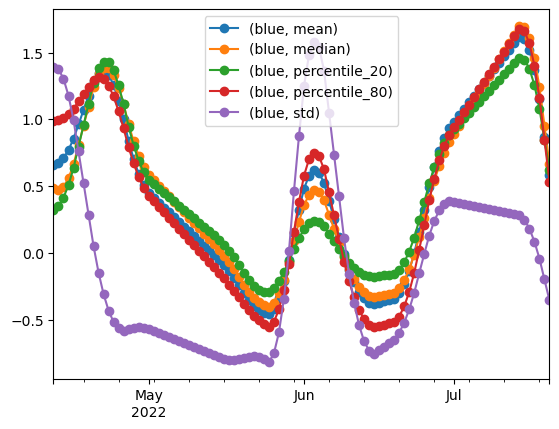

51


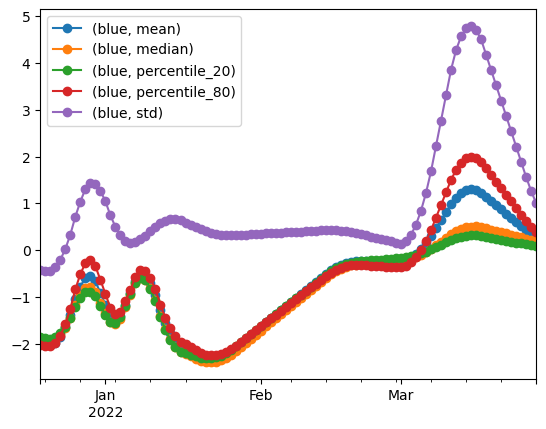

In [146]:
# Visualize data for one random sample
rand = np.random.randint(0, 556)
print(rand)
train_ts_data.loc[rand].filter(like='blue').plot(marker='o')
# [plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

# Visualize data for one random sample
rand = np.random.randint(0, 99)
print(rand)
sub_ts_data.loc[rand].filter(like='blue').plot(marker='o')
# [plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

# # Visualize data for one random sample
# rand = np.random.randint(idx_high.to_series().sample().values[0])
# print(rand)
# train_sent2_data.loc[rand].filter(like='blue').plot(color=['r', 'g', 'b', 'crimson', 'tomato', 'skyblue'], marker='o')
# # [plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
# plt.show();

# # Visualize data for one random sample
# rand = np.random.randint(0, 99)
# print(rand)
# sub_sent2_data.loc[78].filter(like='nd').plot(color=['r', 'g', 'b', 'crimson', 'tomato', 'skyblue'], marker='o')
# # [plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
# plt.show();


### Detect TS Anomalies

In [35]:
# import torch
import torch.nn as nn

# Define a simple RNN model with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Feed input sequence through the LSTM
        out, _ = self.rnn(x, (h0, c0))

        # Pass the output sequence through a fully connected layer
        out = self.fc(out)

        return out

# Define a loss function that penalizes large deviations from the predicted values
class AnomalyDetectionLoss(nn.Module):
    def __init__(self, threshold):
        super(AnomalyDetectionLoss, self).__init__()
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        errors = torch.abs(y_pred - y_true)
        mask = errors > self.threshold
        loss = torch.mean(torch.where(mask, errors, torch.zeros_like(errors)))
        return loss

# Define a training function that uses an optimizer to minimize the loss
def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        for i, (inputs) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()), end='\r')

# Define a function to detect anomalies in a time series
def detect_anomalies(model, data, threshold):
    inputs = torch.Tensor(data)
    outputs = model(inputs)
    print(inputs.shape, outputs.shape)
    errors = torch.abs(outputs - inputs)
    mask = errors > threshold
    return mask.squeeze().detach().cpu().numpy()

# # Example usage:
# threshold = 3
# data = torch.Tensor(np.vstack([train_ts_data.values.reshape(557, 100, -1), sub_ts_data.values.reshape(100, 100, -1)])).to('cuda')
# model = RNN(input_size=data.shape[2], hidden_size=10, output_size=data.shape[2]).to('cuda')
# optimizer = torch.optim.Adam(model.parameters(), lr=10**-4)
# loss_fn = AnomalyDetectionLoss(threshold=threshold)
# train_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
# train_model(model, train_loader, optimizer, loss_fn, num_epochs=20)

In [36]:
# anomaly_mask_train = detect_anomalies(model, data[:557], threshold=threshold*0.35)
# anomaly_mask_sub   = detect_anomalies(model, data[557:], threshold=threshold*0.35)

In [37]:
# anomaly_mask_train_df = pd.DataFrame(anomaly_mask_train.reshape(train_ts_data.shape), index=train_ts_data.index, columns=train_ts_data.columns)
# anomaly_mask_sub_df   = pd.DataFrame(anomaly_mask_sub.reshape(sub_ts_data.shape)  , index=sub_ts_data.index  , columns=sub_ts_data.columns)

In [38]:
# # Join red, blue, green masks, and ndbi, etc, masks
# anomaly_mask_train_df[anomaly_mask_train_df.columns[3:8]] = anomaly_mask_train_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[3:8])
# anomaly_mask_train_df[anomaly_mask_train_df.columns[9:]]  = anomaly_mask_train_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[9:])
# anomaly_mask_train_df = anomaly_mask_train_df.ffill(axis=1)

# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[3:8]] = anomaly_mask_sub_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[3:8])
# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[9:]]  = anomaly_mask_sub_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[9:])
# anomaly_mask_sub_df = anomaly_mask_sub_df.ffill(axis=1)

In [39]:
# iterator = iter(range(0, 50))

In [40]:
# n = next(iterator)
# print(n)
# # n = 18
# # print(pd.DataFrame(anomaly_mask).stack().xs(n))
# for f in range(13):
#     plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
#     train_ts_data.iloc[:, f].xs(n).plot()
#     plt.title(train_ts_data.iloc[:, f].name)
#     plt.show();

In [41]:
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())

In [42]:
# # Fix and then fill nas
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(  pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())

In [43]:
# n = next(iterator)
# print(n)
# n = 1
# # print(pd.DataFrame(anomaly_mask).stack().xs(n))
# for f in range(13):
#     plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
#     train_ts_data.iloc[:, f].xs(n).plot()
#     plt.title(train_ts_data.iloc[:, f].name)
#     plt.show();

In [44]:
# Check that all time_series are the same length
display(train_ts_data.groupby(level=0).count().iloc[:, 0].describe(),
        sub_ts_data.groupby(level=0).count().iloc[:, 0].describe())

count    557.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: vh, dtype: float64

count    100.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: vh, dtype: float64

## Extra constant features (time series descriptors)

In [45]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{100}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{100}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [46]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [47]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        print(row)
        print(row['vv'])
        print(min(row))
        min_vv = min(row['vv'])
        max_vv = max(row['vv'])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row['vv'])
        correlation_vv = sm.tsa.acf(row['vv'])[1]
        permutation_entropy_vv = permutation_entropy(row[0], dx=6,base=2, normalized=True) 
    
        min_vh = min(row['vh'])
        max_vh = max(row['vh'])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row['vh'])
        correlation_vh = sm.tsa.acf(row['vh'])[1]
        permutation_entropy_vh = permutation_entropy(row[1], dx=6, base=2, normalized=True)
    
        min_vv_by_vh = min(row['rvi'])
        max_vv_by_vh = max(row['rvi'])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row['rvi'])
        correlation_vv_by_vh = sm.tsa.acf(row['rvi'])[1]
        permutation_entropy_vv_by_vh = permutation_entropy(row[2], dx=6, base=2, normalized=True)
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, correlation_vv, permutation_entropy_vv,
                          min_vh, max_vh, range_vh,  mean_vh, correlation_vh, permutation_entropy_vh,
                          min_vv_by_vh,  max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, correlation_vv_by_vh, permutation_entropy_vv_by_vh])
    return features_list

In [48]:
def generate_stastical_features_fix(group):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    out = group.agg(['min', 'max', 'ptp', 'mean'])

    for i in range(1):
        out.loc[f'auto_corr_{i+1}', :] = group.apply(lambda x:sm.tsa.acf(x)[i+1])

    out.loc['permut_entropy', :] = group.apply(lambda x:permutation_entropy(x, dx=6, base=2, normalized=True))
        
    return out

In [49]:
descriptors_train = train_ts_data.groupby(level=0).progress_apply(lambda x:generate_stastical_features_fix(x))
descriptors_sub   = sub_ts_data.groupby  (level=0).progress_apply(lambda x:generate_stastical_features_fix(x))

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
# multicols_names = descriptors_train.unstack().columns.map('_'.join)

descriptors_train = descriptors_train.unstack().droplevel(0, axis=1)
# descriptors_train.columns = multicols_names
descriptors_sub   = descriptors_sub.unstack().droplevel(0, axis=1)
# descriptors_sub.columns   = multicols_names

display(descriptors_train.head(2), descriptors_sub.head(2))

,min,max,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,-2.089145,1.238413,3.327558,0.002894,0.983148,0.276233,-1.669874,1.725758,3.395632,0.052259,...,3.291788,-0.431750,0.987489,0.245275,-2.401112,1.520565,3.921677,-0.440500,0.988317,0.254510
1,0.218617,1.615500,1.396883,0.969161,0.965223,0.346638,-0.094739,1.937925,2.032664,0.967319,...,2.188519,-0.321826,0.984836,0.252806,-1.215908,1.566639,2.782548,0.278308,0.976191,0.282284


,min,max,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,-2.245738,0.944572,3.190310,-0.426536,0.993448,0.254623,-2.072980,0.704118,2.777098,-0.342714,...,0.000000,-1.908320,0.990000,-0.000000,-1.509601,-1.509601,0.000000,-1.509601,NaN,-0.000000
1,-1.595795,0.766447,2.362242,-0.101332,0.979821,0.326659,-1.227331,1.999833,3.227164,-0.032074,...,3.127167,-0.068282,0.978443,0.126529,-1.509601,1.379139,2.888739,0.425671,0.941573,0.298854


In [51]:
train_const_data = pd.concat([train_const_data, descriptors_train], axis=1).drop(['start_of_harvest', 'target_class', 'date_of_harvest'], axis=1)
sub_const_data   = pd.concat([sub_const_data  , descriptors_sub], axis=1).drop(['start_of_harvest', 'date_of_harvest'], axis=1)
train_const_data.head(2)

,field_size,rice_yield,season_WS,intensity_T,dayofyear_of_harvest,min,max,ptp,mean,auto_corr_1,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,3.40,5500,0,1,196,-2.089145,1.238413,3.327558,0.002894,0.983148,...,3.291788,-0.431750,0.987489,0.245275,-2.401112,1.520565,3.921677,-0.440500,0.988317,0.254510
1,2.43,6000,0,1,196,0.218617,1.615500,1.396883,0.969161,0.965223,...,2.188519,-0.321826,0.984836,0.252806,-1.215908,1.566639,2.782548,0.278308,0.976191,0.282284


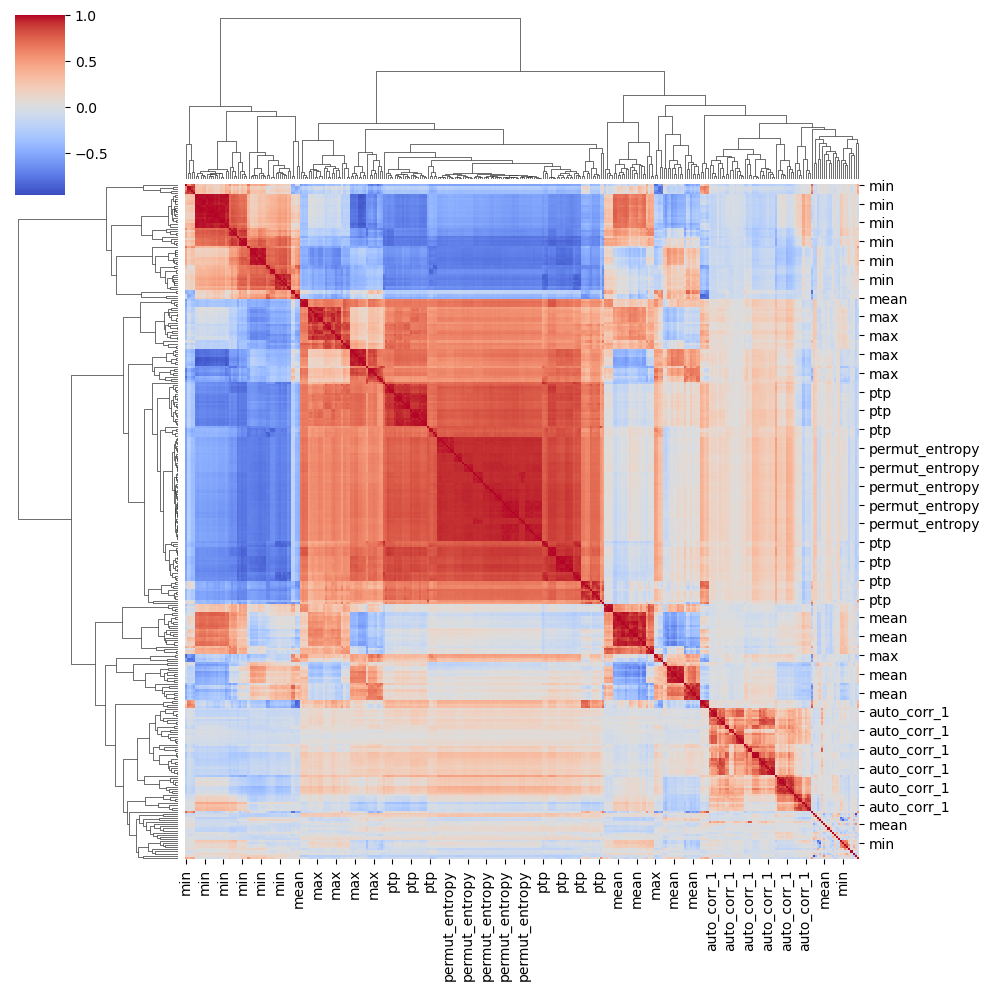

In [52]:
sns.clustermap(train_const_data.corr(), cmap='coolwarm')

In [53]:
train_const_data.isna().sum().sum()
sub_const_data.isna().sum().sum()

16

In [54]:
train_const_data = train_const_data.fillna(0)
sub_const_data   = sub_const_data.fillna(0)

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
scaler = StandardScaler()
selector = SelectPercentile(f_regression, percentile=75)
selector.fit(scaler.fit_transform(train_const_data.drop('rice_yield', axis=1)), train_const_data.rice_yield)

SelectPercentile(percentile=75,
                 score_func=<function f_regression at 0x7fab790c3820>)

<AxesSubplot:>

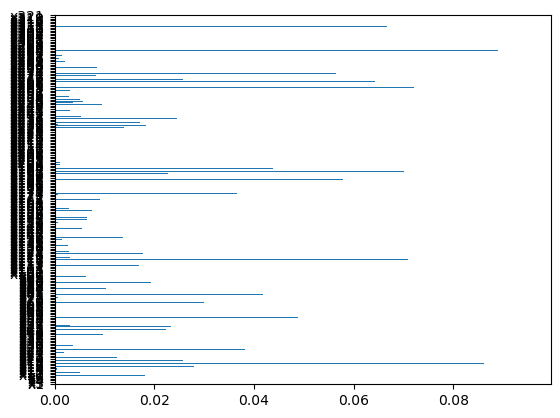

In [56]:
pd.Series(selector.pvalues_[selector.get_support()], index=selector.get_feature_names_out()).plot.barh()

In [57]:
train_const_data_pca = train_const_data.drop('rice_yield', axis=1)
sub_const_data_pca  = sub_const_data

# train_const_data_pca = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(train_const_data.drop('rice_yield', axis=1)))
# sub_const_data_pca   = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(sub_const_data))

# Create Model

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

def TrainTorch(xtrain, ytrain, val_data=(None, None), n_epochs=800, model='convnet'):
    
    # Set boolean for validating
    validating = True
    if val_data==(None, None):
        validating = False

    # To CUDA
    xtrain = xtrain.to('cuda')
    ytrain = ytrain.to('cuda')
    if validating:
        val_data = (val_data[0].to('cuda'), val_data[1].to('cuda'))
    
    # From Torch Tensor to Torch Dataset
    dataset_train = TensorDataset(xtrain, ytrain)
    if validating:
        dataset_val   = TensorDataset(*list(val_data))
   
    class ConvNet(nn.Module):
        def __init__(self, n_features, time_series_length):
            super(ConvNet, self).__init__()
            
            feature_map_depth1 = 3
            n_neurons = 128
            self.conv1 = nn.Conv1d(n_features        , feature_map_depth1, kernel_size=1, stride=1, padding='same')
            self.conv2 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=3, stride=1, padding='same')
            self.conv3 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=5, stride=1, padding='same')
            self.conv4 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=7, stride=1, padding='same')
            self.conv5 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=9, stride=1, padding='same')
            self.conv6 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=11, stride=1, padding='same')
            
            self.globalconv = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=time_series_length, stride=1, padding=0)
            
            self.fc1 = nn.Linear(feature_map_depth1, n_neurons)
            # self.fc2 = nn.Linear(n_neurons, n_neurons)
            self.out = nn.Linear(n_neurons, 1)
            
            self.bn1 = nn.BatchNorm1d(feature_map_depth1)
            self.bn2 = nn.BatchNorm1d(feature_map_depth1)
            self.bn3 = nn.BatchNorm1d(feature_map_depth1)
            self.bn4 = nn.BatchNorm1d(feature_map_depth1)
            self.bn5 = nn.BatchNorm1d(feature_map_depth1)
            self.bn6 = nn.BatchNorm1d(feature_map_depth1)
            
            self.drop = nn.Dropout(0.25)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(2)

            # 1x1 convolution for residual connection
            self.conv_res1 = nn.Conv1d(n_features, feature_map_depth1, kernel_size=1, stride=1, padding='same')
            self.conv_res2 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=5, stride=1, padding='same')
            # self.fc1_res   = nn.Linear(feature_map_depth1, n_neurons)
            # self.fc2_res   = nn.Linear(1, 1)
            
        def forward(self, x):
            x = x.permute(0, 2, 1) # (Para conv1d tiene que entrar batch size, features, seq_length
            # Conv1 Res
            x_res = self.conv_res1(x)  # apply 1x1 convolution to x_res
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            
            # Residual connection 
            # x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
            
            # Conv1 Res
            x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.conv4(x)
            x = self.bn4(x)
            
            # Residual connection 
            # x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
            
            # Conv1 Res
            x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
            x = self.conv5(x)
            x = self.bn5(x)
            x = self.relu(x)
            x = self.conv6(x)
            x = self.bn6(x)
            
            # Residual connection 
            # x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
    
#             # Conv2 Res
#             x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
#             x = self.conv4(x)
#             x = self.relu(x)
#             x = self.conv5(x)
#             x = self.relu(x)

#             # Residual connection
#             x = x + x_res
#             # x = self.pool(x)
            
#             # Conv2 Res
#             x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
#             x = self.conv4(x)
#             x = self.relu(x)
#             x = self.conv5(x)
#             x = self.relu(x)

#             # Residual connection
#             x = x + x_res
            # x = self.pool(x)

            # Max Global Pooling
            x = self.globalconv(x).squeeze()
            # x = torch.max(x, dim=2)[0]
            # x = torch.mean(x, dim=2)
            # x = torch.flatten(x, 1, 2)

#             # Fully connected layers with residual connections
#             x_res = self.fc1_res(x)
#             x = self.fc1(x)
#             x = self.relu(x)
#             x = self.drop(x)
#             x = self.fc2(x)
#             x = self.relu(x)
            
#             # Residual connection
#             x = x + x_res

#             # Fully connected layers with residual connections
#             x_res = self.fc2_res(x)
#             x = self.fc2(x)
#             x = self.relu(x)
#             x = self.drop(x)
#             x = self.fc2(x)
#             x = self.relu(x)
            
#             # Residual connection
#             x = x + x_res
            x = self.fc1(x)
            x = self.relu(x)
            x = self.drop(x)
            x = self.out(x)
            
            return x
        

    class TransformerNet(nn.Module):
        def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout):
            super(TransformerNet, self).__init__()
            self.embedding = nn.Linear(input_size, hidden_size)
            self.pos_embedding = nn.Embedding(100, hidden_size) # positional embedding
            self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout, batch_first=True)
            self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)
            self.out = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            # x = x.permute(0, 2, 1)
            
            seq_length = x.shape[1]
            pos = torch.arange(seq_length).unsqueeze(0).repeat(x.shape[0], 1).to(x.device) # positional indices
            x = self.embedding(x) + self.pos_embedding(pos)
            x = self.transformer_encoder(x)
            x = F.avg_pool1d(x.permute(0, 2, 1), seq_length).squeeze() # average pooling
            return self.out(x)
    
    if model =='transformer':
        model = TransformerNet(input_size=n_features, output_size=1, num_layers=1, hidden_size=64, num_heads=8, dropout=0.1).to('cuda')
    elif model == 'convnet':
        model = ConvNet(n_features, time_series_length).to('cuda')
    else:
        raise Exception('Model has to be "convnet" or "transformer".')
    
    # Training parameters
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=10**(-3.0), weight_decay=10**(-3), maximize=True)
    optimizer = torch.optim.AdamW(    model.parameters(), lr=10**(-4.0), weight_decay=10**(-1), maximize=False) # AdamW, 1 wd, 3.7 lr
    # optimizer = torch.optim.Adam(   model.parameters(), lr=10**(-4.0), weight_decay=10**(-2), maximize=True)
    # optimizer = torch.optim.SGD(    model.parameters(), lr=10**(-2.0), weight_decay=10**(-3), maximize=True)
    
    def smooth_r2_loss(y_pred, y_true, smooth_weight=0.3):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - (ss_res + smooth_weight) / (ss_tot + smooth_weight)
        return r2
    criterion = nn.MSELoss()
    # criterion = smooth_r2_loss
    batch_size = 32
    epochs = n_epochs

    
    # Dataset to Dataloader
    dataloader_train = DataLoader(dataset_train    , batch_size=batch_size, shuffle=True)
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    if validating:
        dataloader_val   = DataLoader(dataset_val      , batch_size=batch_size, shuffle=True)
        n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    else:
        n_batches_val = 1


    from sklearn.metrics import r2_score

    # Instantiate validation metrics
    stopping_counter = 0
    best_val_r2 = -np.inf

    # Training
    for epoch_n, epoch in tqdm(enumerate(range(epochs)), total=epochs):

        train_loss = 0.0
        model.train()
        for i, (x_, y_) in enumerate(dataloader_train):

            preds = model(x_)

            # Compute the loss
            loss = criterion(preds, y_)

            # Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_r2 = 0.0
        if validating:

            for (x__, y__) in dataloader_val:

                # Forward Pass
                preds = model(x__)

                # Find the R2 score
                r2 = r2_score(y__.detach().cpu().numpy(), preds.detach().cpu().numpy())

                # Calculate R2 score
                val_r2 += r2

            patience = 20
            if val_r2 <= best_val_r2:
                stopping_counter += 1
                if stopping_counter == patience:
                    print(f'{stopping_counter} time(s) has the R2 score not improved. Finishing training...\n',
                        f'best epoch: {epoch_n - patience} training loss: {round(train_loss/n_batches_train, 4)} best val_R2: {np.round(best_val_r2/n_batches_val, 4)}'
                         )
                    break
            else:
                best_val_r2 = val_r2
                best_model = model
                stopping_counter = 0

        print(f'Training loss: {train_loss/n_batches_train:.4f}', 
        f'Validation R2 score: {val_r2/n_batches_val:.4f}',
        f'Stopping counter: {stopping_counter:02d}    ',
        end='\r')

    if validating:
        return best_model, best_val_r2/n_batches_val
    else:
        return model

In [92]:
# Prepare data for training

# concat ts data with constant features
x = pd.concat([train_const_data_pca, train_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop('season_WS', axis=1)
xsub = pd.concat([sub_const_data_pca, sub_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop('season_WS', axis=1)

assert (x.columns == xsub.columns).all()

y = train_const_data.rice_yield.groupby(level=0).first().values.reshape(-1, 1)

# Reshape time series
n_samples = len(x)//100
time_series_length = (len(x) // n_samples)*0+100
n_features = x.shape[1]

# Convert to numpy array and reshape (n, length, features)
x    = x.values.reshape(n_samples, time_series_length, n_features)
xsub = xsub.values.reshape(  len(xsub.index.levels[0]), time_series_length, n_features)

display(x.shape, y.shape, xsub.shape)

(557, 100, 374)

(557, 1)

(100, 100, 374)

In [93]:
rand_state = np.random.randint(1, 373737)
# rand_state = 39996
# rand_state = 222191
# 93344
# rand_state = 278122
# rand_state = 205873 # buena correlacion con leaderboard
# rand_state = 255631
rand_state = 361712
print(rand_state)

# Split test set
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(1, random_state=rand_state, test_size=0.2)
idx_fulltrain, idx_test = list(splitter.split(x, crop_yield_data.target_class))[0]
# Make splits
xfulltrain = x[idx_fulltrain]
yfulltrain = y[idx_fulltrain]
xtest      = x[idx_test]
ytest      = y[idx_test]
target_fulltrain = crop_yield_data.target_class.loc[idx_fulltrain]
target_test      = crop_yield_data.target_class.loc[idx_test]

# Use train set for cross-validation
from sklearn.model_selection import KFold, StratifiedKFold
def KFoldTraining(x_, y_, **kwargs):

    # K folds
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state+2)
    kfolds = list(kfold.split(x_, y_))
    
    # For each fold, scale data, train and append models
    models = []
    for i, fold in enumerate(kfolds):
        # Splitting
        train_idx, val_idx = fold[0], fold[1]
        xval      = x_[val_idx]
        yval      = y_[val_idx]
        xtrain    = x_[train_idx]
        ytrain    = y_[train_idx]
        
        # Add noise to ytrain
        # ytrain = ytrain + np.random.normal(0, 200, size=ytrain.shape)

        # Scaling
        # Instantiate scalers
        from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        xtrain = scaler_x.fit_transform(xtrain.reshape(-1, xtrain.shape[2])).reshape(xtrain.shape)
        xval   = scaler_x.transform(xval.reshape(-1, xval.shape[2])).reshape(xval.shape)
        ytrain  = scaler_y.fit_transform(ytrain)
        yval    = scaler_y.transform(yval)

        # Cast to Tensors
        xtrain = torch.Tensor(xtrain)
        ytrain = torch.Tensor(ytrain)
        xval   = torch.Tensor(xval)
        yval   = torch.Tensor(yval)

        # Train and append model
        models.append(TrainTorch(xtrain, ytrain, (xval, yval), **kwargs))
        
    return models

def FullDataTraining(x, y, **kwargs):
    # Scaling
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    x    = scaler_x.fit_transform(x.reshape(-1, x.shape[2])).reshape(x.shape)
    y    = scaler_y.fit_transform(y)

    # Cast to Tensors
    x    = torch.Tensor(x)
    y    = torch.Tensor(y)

    # Train and append model
    return TrainTorch(x, y, **kwargs)

361712


In [94]:
models_losses = KFoldTraining(xfulltrain, yfulltrain, model='convnet')

models = np.array(models_losses)[:, 0]
r2_scores = np.array(models_losses)[:, 1]

print('Average R2 on k-fold:' , r2_scores.mean())

model = FullDataTraining(xfulltrain, yfulltrain, n_epochs=60)

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 37 training loss: 0.408 best val_R2: 0.5885


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 91 training loss: 0.3681 best val_R2: 0.5732


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 34 training loss: 0.4538 best val_R2: 0.6196


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 90 training loss: 0.3474 best val_R2: 0.5077
Average R2 on k-fold: 0.5722670644623926


  0%|          | 0/60 [00:00<?, ?it/s]

In [95]:
model = []
for i in [40, 50, 60, 70]:
    model.append(FullDataTraining(xfulltrain, yfulltrain, n_epochs=i))
model = np.array(model)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [96]:
models_losses_transformer = KFoldTraining(xfulltrain, yfulltrain, model='transformer')

models_tr = np.array(models_losses_transformer)[:, 0]
r2_scores = np.array(models_losses_transformer)[:, 1]
print('Average R2 on k-fold:' , r2_scores.mean())

model_tr = FullDataTraining(xfulltrain, yfulltrain, n_epochs=50, model='transformer')

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 29 training loss: 0.2559 best val_R2: 0.5647


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 36 training loss: 0.2613 best val_R2: 0.6269


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 20 training loss: 0.3058 best val_R2: 0.6437


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 50 training loss: 0.228 best val_R2: 0.5153
Average R2 on k-fold: 0.5876308200240039


  0%|          | 0/50 [00:00<?, ?it/s]

## Evaluate with test set

### Function and Scaling

In [155]:
def MakePredictions(model, xtest):
    if type(model) is np.ndarray or type(model) is list:
        kfold_preds = []
        if type(xtest) != torch.Tensor:
            xtest = torch.Tensor(xtest)
        for m in model:
            kfold_preds.append(m(xtest.to('cuda')).cpu().detach().numpy().squeeze())
        preds = np.mean(np.array(kfold_preds), 0)
    else:
        try:
            preds = model.predict(xtest).squeeze()
        except:
            if type(xtest) != torch.Tensor:
                xtest = torch.Tensor(xtest)
        preds = model(xtest.to('cuda')).cpu().detach().numpy().squeeze()

    return preds

def EvaluationPlot(model, xtest, ytest, title=''):
                   
    preds = MakePredictions(model, xtest)
    
    # comparison preds, real
    from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
    
    preds_df = pd.DataFrame(pd.concat([pd.Series(preds),
                                       pd.Series(ytest.squeeze())], axis=1))\
    .assign(error=lambda x:x[1] - x[0],
            mae=lambda x:mae(x[1], x[0]),
            mse=lambda x:np.sqrt(mse(x[1], x[0])),
            r2=lambda x:r2(x[1], x[0]))

    preds_df.pipe(lambda x:sns.regplot(data=x, x=x[1], y=x[0]))
    plt.plot(np.arange(preds_df[1].min(), preds_df[1].max()+1), np.arange(preds_df[1].min(), preds_df[1].max()+1), c='k', ls='-', alpha=0.35)
    plt.title(title)
    plt.show()
    
    display(preds_df.head(5))

In [98]:
# Scalers for test set
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
scaler_x_fulltrain = StandardScaler()
scaler_y_fulltrain = StandardScaler()
xfulltrain = scaler_x_fulltrain.fit_transform(xfulltrain.reshape(-1, xfulltrain.shape[2])).reshape(xfulltrain.shape)
yfulltrain = scaler_y_fulltrain.fit_transform(yfulltrain)
xtest = scaler_x_fulltrain.transform(xtest.reshape(-1, xtest.shape[2])).reshape(xtest.shape)
ytest = scaler_y_fulltrain.transform(ytest)

scaler_x_sub = StandardScaler()
scaler_y_sub = StandardScaler()
scaler_x_sub.fit(x.reshape(-1, x.shape[2]))
scaler_y_sub.fit(y)
xsub = scaler_x_sub.transform(xsub.reshape(-1, xsub.shape[2])).reshape(xsub.shape)

In [99]:
# Load 0.62 submission
ytrue = scaler_y_sub.transform(pd.read_csv('Version 11.csv').iloc[:, -1].rename('rice_yield').values.round(-1).reshape(-1, 1)).squeeze()

### sklearn benchmark

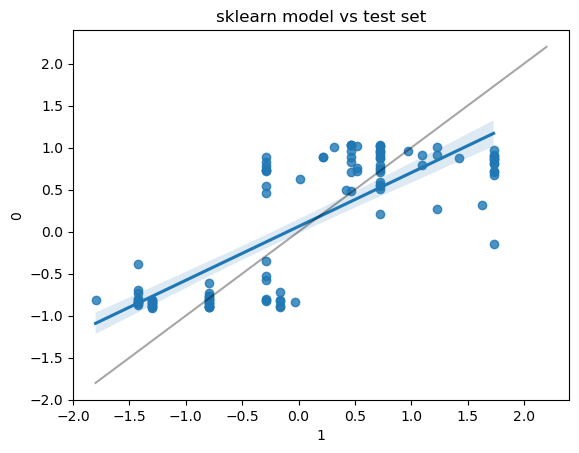

,0,1,error,mae,mse,r2
0,-0.796851,-1.422493,-0.625641,0.480733,0.599369,0.648105
1,0.889018,0.216578,-0.672439,0.480733,0.599369,0.648105
2,0.269660,1.225237,0.955578,0.480733,0.599369,0.648105
3,0.506950,0.720908,0.213958,0.480733,0.599369,0.648105
4,0.734310,-0.287751,-1.022061,0.480733,0.599369,0.648105


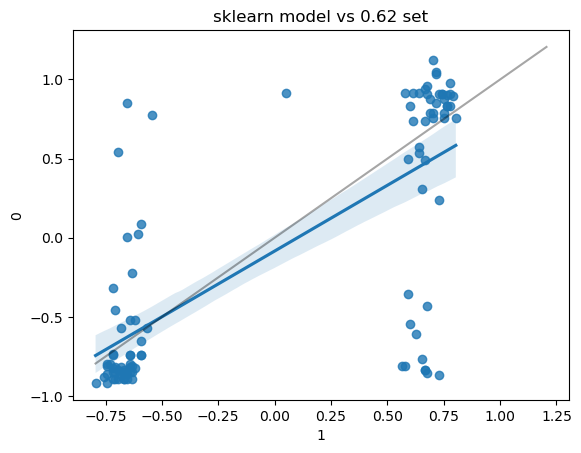

,0,1,error,mae,mse,r2
0,-0.838064,0.665169,1.503233,0.351453,0.555038,0.329555
1,-0.891428,-0.630723,0.260705,0.351453,0.555038,0.329555
2,-0.838064,-0.668467,0.169597,0.351453,0.555038,0.329555
3,0.308427,0.652588,0.344160,0.351453,0.555038,0.329555
4,-0.739188,-0.643304,0.095883,0.351453,0.555038,0.329555


In [100]:
# sklearn benchmark
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR

# sk_model = SVR(C=10**4.5)
sk_model = AdaBoostRegressor(n_estimators=150)
sk_model.fit(xfulltrain.mean(1), yfulltrain)

EvaluationPlot(sk_model, xtest.mean(1), ytest, 'sklearn model vs test set')
EvaluationPlot(sk_model, xsub.mean(1) , ytrue, 'sklearn model vs 0.62 set')

### NN Models

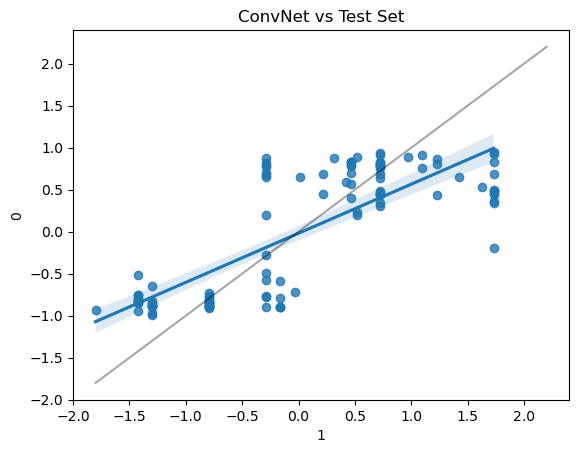

,0,1,error,mae,mse,r2
0,-0.843349,-1.422493,-0.579144,0.47988,0.619099,0.624557
1,0.687014,0.216578,-0.470435,0.47988,0.619099,0.624557
2,0.431608,1.225237,0.793629,0.47988,0.619099,0.624557
3,0.442960,0.720908,0.277948,0.47988,0.619099,0.624557
4,0.199144,-0.287751,-0.486895,0.47988,0.619099,0.624557


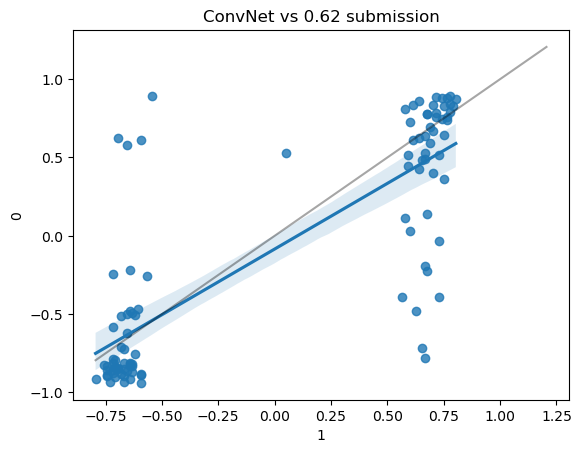

,0,1,error,mae,mse,r2
0,-0.193152,0.665169,0.858321,0.282108,0.44659,0.565955
1,-0.831443,-0.630723,0.200720,0.282108,0.44659,0.565955
2,-0.848261,-0.668467,0.179793,0.282108,0.44659,0.565955
3,0.485345,0.652588,0.167243,0.282108,0.44659,0.565955
4,-0.819849,-0.643304,0.176545,0.282108,0.44659,0.565955


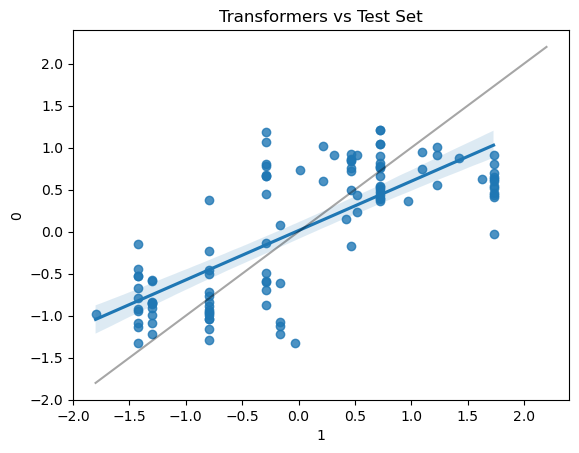

,0,1,error,mae,mse,r2
0,-0.446599,-1.422493,-0.975893,0.542538,0.670934,0.559056
1,1.022367,0.216578,-0.805789,0.542538,0.670934,0.559056
2,0.553101,1.225237,0.672137,0.542538,0.670934,0.559056
3,0.398123,0.720908,0.322785,0.542538,0.670934,0.559056
4,0.447878,-0.287751,-0.735629,0.542538,0.670934,0.559056


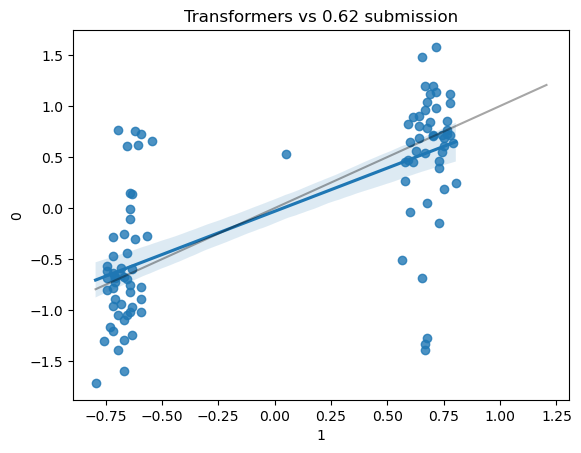

,0,1,error,mae,mse,r2
0,-1.385682,0.665169,2.050851,0.431244,0.621775,0.158637
1,-1.241492,-0.630723,0.610770,0.431244,0.621775,0.158637
2,-0.253256,-0.668467,-0.415211,0.431244,0.621775,0.158637
3,1.479050,0.652588,-0.826462,0.431244,0.621775,0.158637
4,-0.755249,-0.643304,0.111944,0.431244,0.621775,0.158637


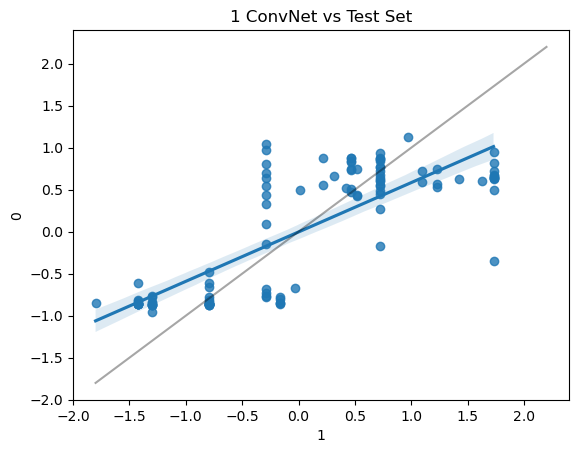

,0,1,error,mae,mse,r2
0,-0.856937,-1.422493,-0.565556,0.478245,0.608327,0.637508
1,0.872163,0.216578,-0.655584,0.478245,0.608327,0.637508
2,0.535350,1.225237,0.689888,0.478245,0.608327,0.637508
3,0.270070,0.720908,0.450838,0.478245,0.608327,0.637508
4,0.435546,-0.287751,-0.723297,0.478245,0.608327,0.637508


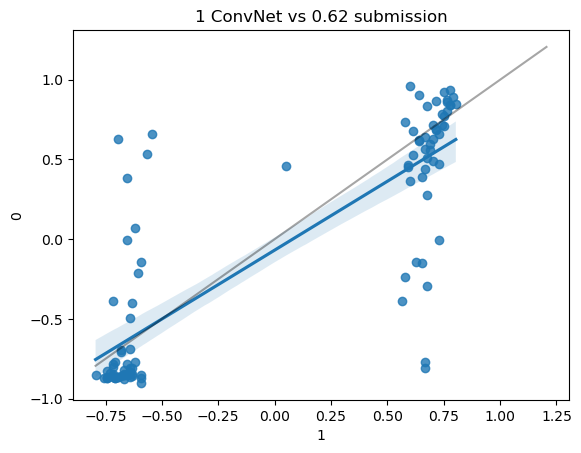

,0,1,error,mae,mse,r2
0,-0.808415,0.665169,1.473584,0.268551,0.42019,0.615755
1,-0.855151,-0.630723,0.224429,0.268551,0.42019,0.615755
2,-0.878052,-0.668467,0.209585,0.268551,0.42019,0.615755
3,0.386922,0.652588,0.265666,0.268551,0.42019,0.615755
4,-0.832755,-0.643304,0.189451,0.268551,0.42019,0.615755


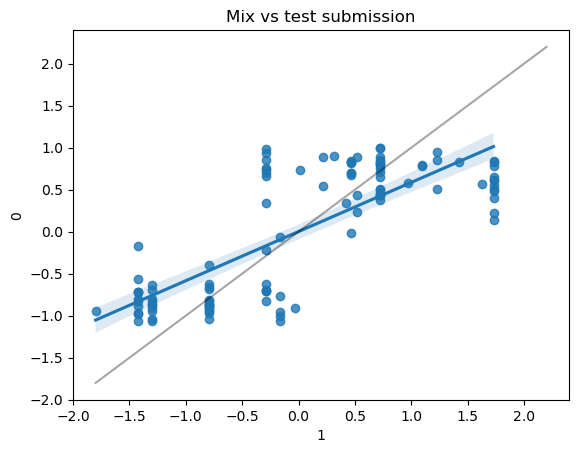

,0,1,error,mae,mse,r2
0,-0.724219,-1.422493,-0.698273,0.501633,0.630941,0.610056
1,0.887745,0.216578,-0.671167,0.501633,0.630941,0.610056
2,0.505443,1.225237,0.719794,0.501633,0.630941,0.610056
3,0.438436,0.720908,0.282472,0.501633,0.630941,0.610056
4,0.343468,-0.287751,-0.631219,0.501633,0.630941,0.610056


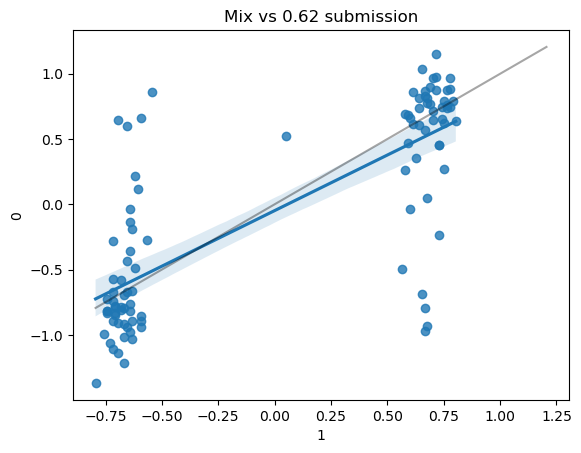

,0,1,error,mae,mse,r2
0,-0.796721,0.665169,1.461890,0.329927,0.504571,0.445933
1,-1.034978,-0.630723,0.404255,0.329927,0.504571,0.445933
2,-0.697730,-0.668467,0.029263,0.329927,0.504571,0.445933
3,1.033552,0.652588,-0.380964,0.329927,0.504571,0.445933
4,-0.762671,-0.643304,0.119367,0.329927,0.504571,0.445933


In [101]:
EvaluationPlot(models, xtest, ytest, 'ConvNet vs Test Set')
EvaluationPlot(models, xsub , ytrue, 'ConvNet vs 0.62 submission')

EvaluationPlot(models_tr, xtest, ytest, 'Transformers vs Test Set')
EvaluationPlot(models_tr, xsub , ytrue, 'Transformers vs 0.62 submission')

EvaluationPlot(model, xtest, ytest, '1 ConvNet vs Test Set')
EvaluationPlot(model, xsub , ytrue, '1 ConvNet vs 0.62 submission')

EvaluationPlot(np.append(models, models_tr), xtest, ytest, 'Mix vs test submission')
EvaluationPlot(np.append(models, models_tr), xsub , ytrue, 'Mix vs 0.62 submission')

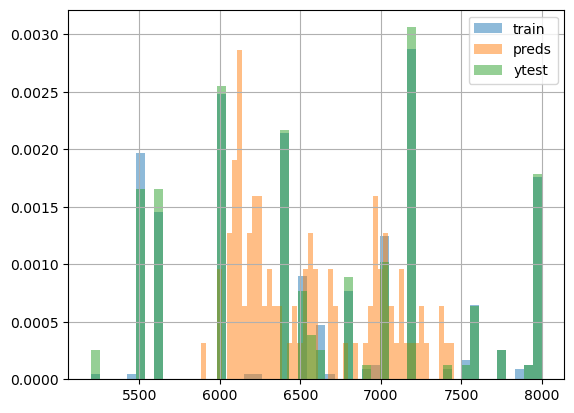

In [812]:
# Distribution of target variables
pd.Series(yfulltrain.squeeze()).hist(density=True, bins=50, label='train', alpha=0.5)
pd.Series(preds).hist(density=True, bins=50, label='preds', alpha=0.5)
pd.Series(scaler_y.inverse_transform(ytest.reshape(-1, 1)).squeeze()).hist(density=True, bins=50, label='ytest', alpha=0.5)
plt.legend()

## Retrain with full data

In [103]:
# Train KFolds with validation data
models = KFoldTraining(x, y, model='convnet')

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 52 training loss: 0.4628 best val_R2: 0.602


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 56 training loss: 0.3866 best val_R2: 0.548


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 62 training loss: 0.4099 best val_R2: 0.5716


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 69 training loss: 0.4631 best val_R2: 0.5928


In [104]:
# Average validation loss
r2_scores = np.array(models)[:, 1]
models = np.array(models)[:, 0]

print('Average R2 on k-fold:' , r2_scores.mean())

Average R2 on k-fold: 0.5786099872374888


In [150]:
# Train once on all data
model_full = []
for i in range(5):
    model_full.append(FullDataTraining(x, y, n_epochs=50))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 207795 msq: 0.5206 r2: 0.476

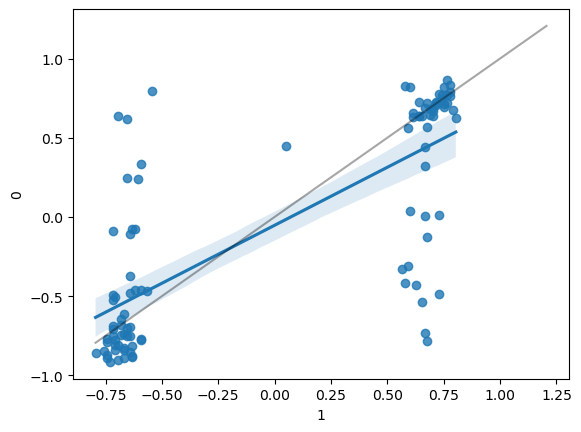

,0,1,error,mae,mse,r2
0,0.004561,0.665169,0.660608,0.28678,0.47838,0.501962
1,-0.883699,-0.630723,0.252976,0.28678,0.47838,0.501962
2,-0.838130,-0.668467,0.169663,0.28678,0.47838,0.501962
3,0.634017,0.652588,0.018571,0.28678,0.47838,0.501962
4,-0.697308,-0.643304,0.054003,0.28678,0.47838,0.501962


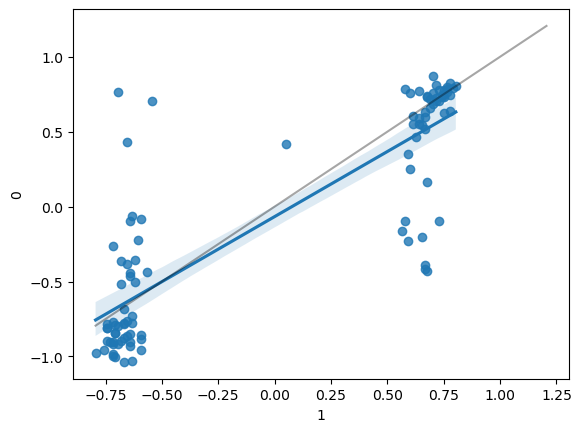

,0,1,error,mae,mse,r2
0,-0.388795,0.665169,1.053964,0.253031,0.39247,0.66478
1,-1.029476,-0.630723,0.398753,0.253031,0.39247,0.66478
2,-0.781055,-0.668467,0.112588,0.253031,0.39247,0.66478
3,0.546982,0.652588,0.105605,0.253031,0.39247,0.66478
4,-0.932230,-0.643304,0.288926,0.253031,0.39247,0.66478


In [156]:
EvaluationPlot(models, xsub, ytrue)
EvaluationPlot(model_full, xsub, ytrue)

# Make predictions and submit

In [656]:
kfold_preds = []
for m in np.array(models)[:, 0]:
    kfold_preds.append(m(xsub.to('cuda')).cpu().detach().numpy())

array([6322.289 , 5813.0635, 6010.5127, 7066.063 , 5890.3564, 6554.8003,
       5807.588 , 6555.9565, 7204.363 , 7111.366 , 7191.5073, 5932.6074,
       5868.781 , 5957.5303, 6349.32  , 7247.642 , 5871.348 , 6262.907 ,
       5831.4155, 6911.505 , 7248.541 , 5850.396 , 6555.886 , 6002.724 ,
       6762.401 , 7211.776 , 6504.105 , 5911.7734, 5912.445 , 5952.086 ,
       6012.4414, 5986.449 , 7224.5596, 7104.5635, 7215.555 , 6832.    ,
       6018.2363, 6564.074 , 6965.4756, 6341.6665, 7254.463 , 5985.827 ,
       6281.0767, 7213.2603, 5996.8013, 6024.8716, 5958.3384, 7205.332 ,
       5919.249 , 6222.776 , 7070.0474, 7263.6436, 6326.128 , 7259.968 ,
       6974.005 , 7222.606 , 7125.4907, 7211.523 , 6090.7686, 6049.1294,
       5945.487 , 6300.457 , 6013.6978, 6007.167 , 7100.731 , 7191.2285,
       6998.1704, 7322.5684, 7231.61  , 5918.398 , 6421.085 , 7274.3706,
       5926.6304, 6233.174 , 7140.4146, 5903.879 , 6290.104 , 5962.3765,
       7286.1377, 7240.415 , 5855.451 , 7255.0796, 

In [657]:
# sub_preds = np.array(kfold_preds).mean(0)
# # sub_preds = model_full(xsub.to('cuda')).cpu().detach().numpy()
sub_preds = scaler_y_sub.inverse_transform(MakePredictions(model_full, xsub).reshape(-1, 1)).squeeze()

sub_preds

array([5983.059 , 5793.4097, 5875.6357, 6334.9663, 5838.802 , 6163.015 ,
       5890.7456, 5946.6655, 7241.3438, 7331.6367, 7354.8096, 5804.381 ,
       5931.4395, 6002.09  , 6655.969 , 7294.3745, 5759.897 , 6085.6074,
       5745.5156, 6762.9795, 7312.645 , 6006.153 , 6377.354 , 6116.505 ,
       6519.7153, 7360.9233, 6452.534 , 5978.7373, 5876.349 , 6034.54  ,
       5924.1436, 5778.036 , 7128.96  , 6617.213 , 7185.6313, 6464.903 ,
       5776.0474, 5817.91  , 6876.103 , 5799.3413, 7383.88  , 5803.858 ,
       5915.441 , 7444.772 , 5821.679 , 5971.394 , 5845.731 , 7188.3833,
       5869.651 , 6863.217 , 7003.4546, 7331.749 , 6187.22  , 7368.1685,
       6223.884 , 7450.6577, 7365.497 , 7281.5737, 5743.6665, 5972.136 ,
       5961.681 , 5821.761 , 5819.095 , 5774.721 , 6682.7876, 7520.931 ,
       6861.9   , 7413.6763, 7506.282 , 5882.8413, 5872.7046, 7187.389 ,
       5891.5137, 5902.7593, 7354.942 , 5825.301 , 5847.9375, 5833.6206,
       7399.184 , 7407.319 , 5708.6934, 7197.59  , 

In [658]:
submission_df = pd.read_csv('Challenge_2_submission_template.csv')
submission_df['Predicted Rice Yield (kg/ha)'] = sub_preds
submission_df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,5983.059082
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,5793.409668
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,5875.635742
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,6334.966309
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,5838.801758


In [659]:
submission_df.to_csv('Version 13.csv', index=False)